In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import os
def fetch_image_dataset(path:str):
    apple = {}
    grape = {}
    for subd in os.listdir(path):
        # inside images
        if subd.startswith('Apple'):
            # apple = {'apple_healthy': [], 'apple_black_rot': [], 'apple_cedar_rust': [], 'apple_scab': []}
            apple[subd] = []
            for img in os.listdir(os.path.join(path,subd)):
                apple[subd].append(img)
        elif subd.startswith('Grape'):
            # grape = {'grape_healthy': [], 'grape_black_rot': [], 'apple_esca': [], 'apple_spot': []}
            grape[subd] = []
            for img in os.listdir(os.path.join(path,subd)):
                grape[subd].append(img)
        else:
            print('Plant not supported')
    return apple, grape

In [4]:
apple, grape = fetch_image_dataset('C:/Users/khali/Desktop/Leaffliction/images')

In [5]:
def analyze_distribution(data:dict):
    dist = {}
    for k,v in data.items():
        dist[k] = len(v)
    return dist

In [6]:
apple_dist = analyze_distribution(apple)
grape_dist = analyze_distribution(grape)

In [13]:

def plot_distribution(data: dict):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Define color palette
    colors = plt.cm.tab10.colors
    
    # Bar chart
    ax1.bar(data.keys(), data.values(), color=colors[:len(data)])
    # Pie chart
    ax2.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', colors=colors[:len(data)])
    
    plt.title(f'{list(data.keys())[0][:5]} Distribution')
    plt.tight_layout()
    plt.show()


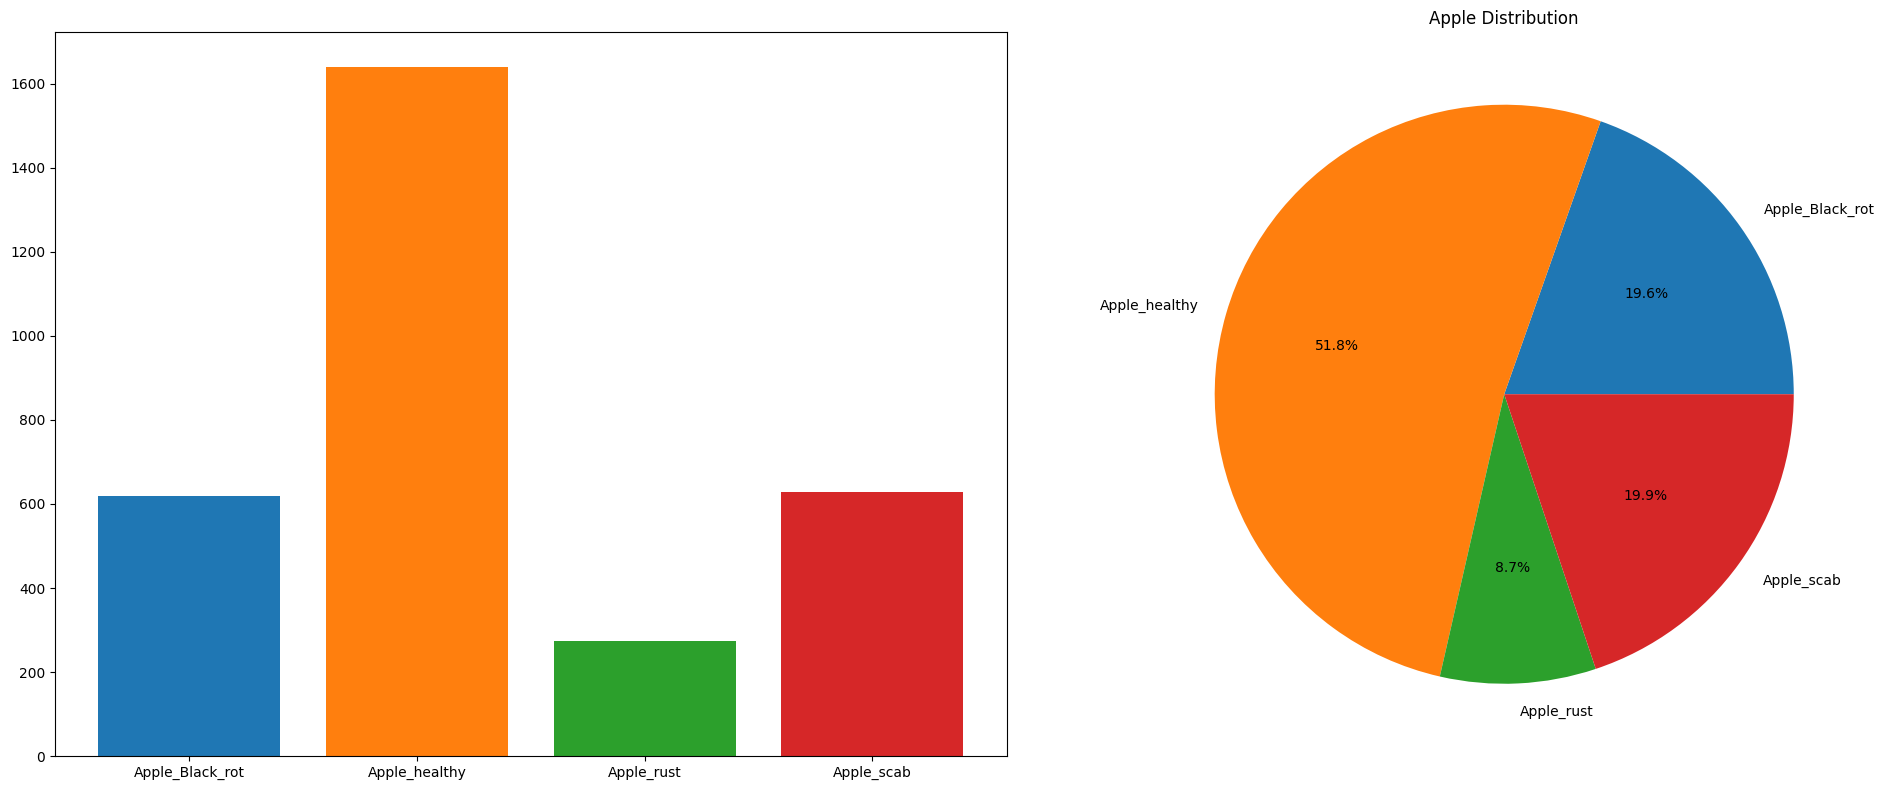

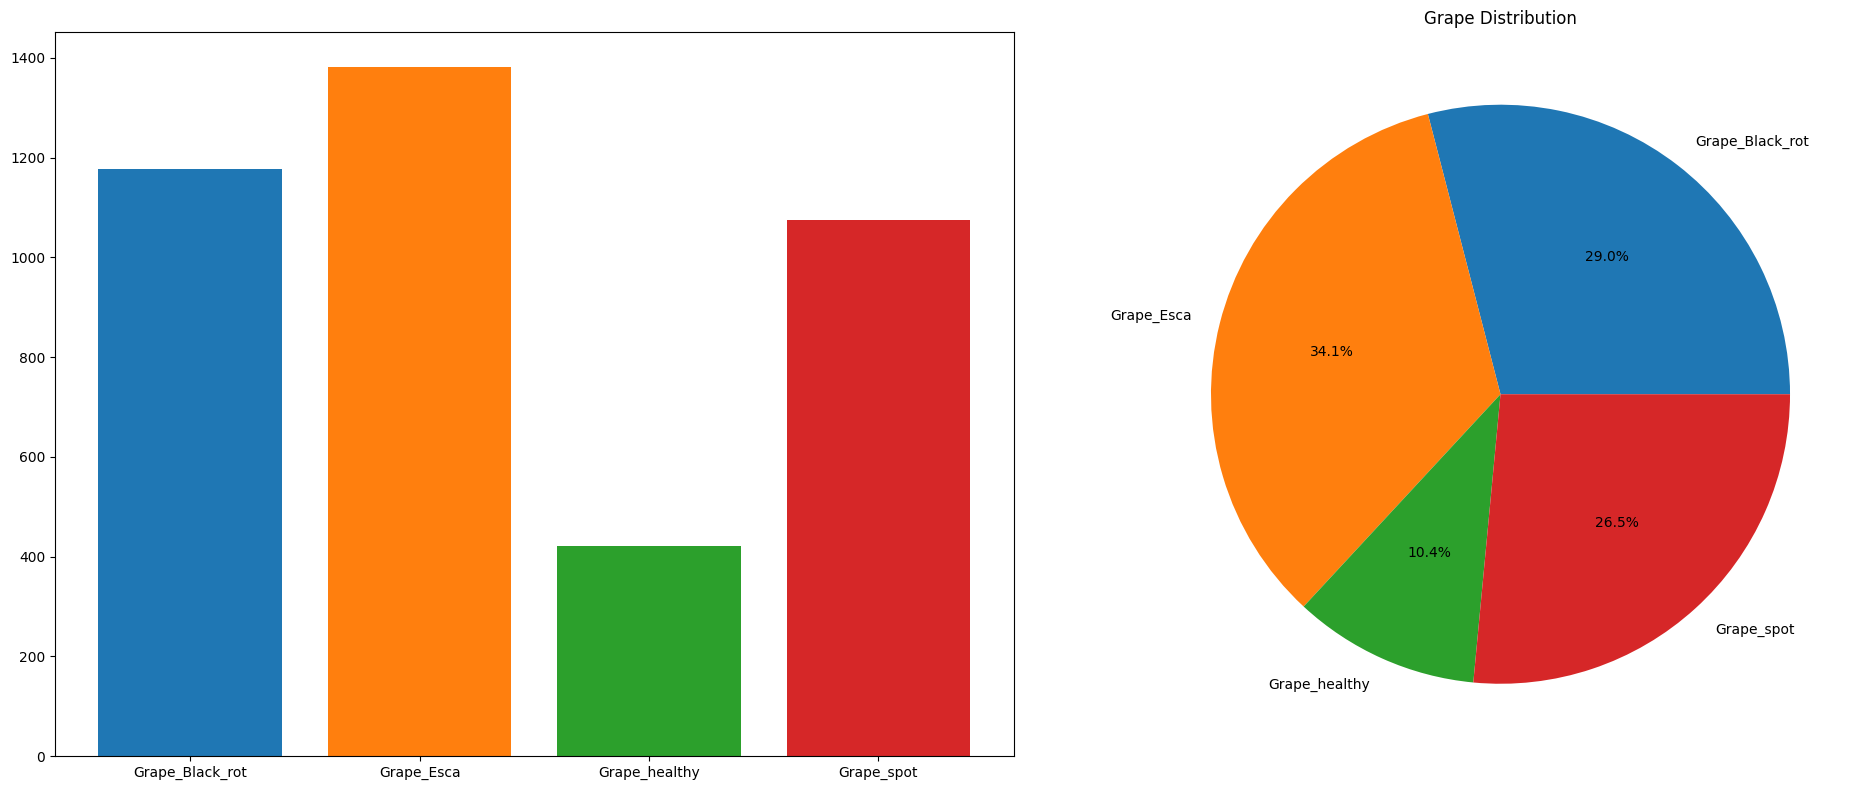

In [14]:
plot_distribution(apple_dist)
plot_distribution(grape_dist)

In [66]:
import torch
from torchvision.transforms import v2
from PIL import Image

def Augmentation(path:str):
    for subd in os.listdir(path):
        newpath = os.path.join(path, subd)
        for img in os.listdir(newpath):
            # Load image
            image = Image.open(os.path.join(newpath +'/', img))
            # Flip
            flip = v2.RandomHorizontalFlip(p=1)(image)
            flip.save(os.path.join(newpath, img.split('.')[0]+'_flip.jpg'))
            # Rotate
            rotate = v2.RandomRotation(degrees=45)(image)
            rotate.save(os.path.join(newpath, img.split('.')[0]+'_rotate.jpg'))
            # Skew
            skew = v2.RandomAffine(degrees=0, shear=45)(image)
            skew.save(os.path.join(newpath, img.split('.')[0]+'_skew.jpg'))
            # Shear
            shear = v2.RandomAffine(degrees=0, shear=45)(image)
            shear.save(os.path.join(newpath, img.split('.')[0]+'_shear.jpg'))
            # Crop
            crop = v2.RandomResizedCrop(size=(200,200))(image)
            crop.save(os.path.join(newpath, img.split('.')[0]+'_crop.jpg'))
            # Distortion
            distortion = v2.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(image)
            distortion.save(os.path.join(newpath, img.split('.')[0]+'_distortion.jpg'))

In [ ]:
path = "C:\\Users\\khali\\Desktop\\LEAFFLICTION\\images"
Augmentation(path)